In [24]:
import pprint as pp
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
from scipy.stats import uniform as sp_rand

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,confusion_matrix, classification_report
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score,\
                            make_scorer, fbeta_score, roc_curve, auc, \
                            roc_auc_score, precision_recall_curve, confusion_matrix

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc

In [5]:
df = pd.read_csv('UCI_Credit_Card 2.csv')

### Feature Engineering:
Discretization of limit balance  
Singular Value Decomposition

In [6]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
df['LIMIT_BAL'] = est.fit_transform(df[['LIMIT_BAL']])

In [7]:
def svd(X):
  # Data matrix X, X doesn't need to be 0-centered
  n, m = X.shape
  # Compute full SVD
  U, Sigma, Vh = np.linalg.svd(X, 
      full_matrices=False, # It's not necessary to compute the full matrix of U or V
      compute_uv=True)
  # Transform X with SVD components
  X_svd = np.dot(U, np.diag(Sigma))
  return X_svd

In [8]:
features = df.iloc[:,:-1]
svd(features)

array([[-3.44991354e+03, -3.28613213e+03, -2.63784683e+00, ...,
        -9.66091372e-01, -8.24903439e-01,  6.31529838e-01],
       [-6.96827769e+03,  1.97617144e+03,  3.40374255e+02, ...,
        -2.77106939e-01, -1.92118897e-01,  9.72228163e-01],
       [-4.20656521e+04, -4.17617940e+03, -3.76435264e+03, ...,
        -1.11766450e-02, -1.44032447e-01,  1.98435326e-02],
       ...,
       [-2.91873167e+04,  2.36289190e+04, -4.85606291e+03, ...,
         7.19192360e-01,  7.79800551e-01, -7.92627857e-01],
       [-1.14673731e+05,  1.62798250e+04,  4.73826995e+04, ...,
         6.35641510e-03,  3.08467377e-01, -4.29245755e-01],
       [-9.76942238e+04, -1.67302838e+04,  9.16962088e+03, ...,
         1.02137171e-02,  2.47832862e-01, -2.29459959e-02]])

In [9]:
X = features
y = df['default.payment.next.month']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42, stratify=y)

In [161]:
classifiers = {'KNN': KNeighborsClassifier(), 
               'LR': LogisticRegression(penalty = 'l1', max_iter = 10000, solver = 'liblinear'), 
               'RF': RandomForestClassifier(max_depth = 3), 
               'SVM': svm.SVC()
              }

samplers = {'sampling': [None, 
                         SMOTE(random_state = 42), 
                         ADASYN(random_state = 42)]
           }

results_dict = {}

# #n_splits = 1 in ShuffleSplits allows us to avoid cross-validation
# #cross-validating with n_jobs = -1 with sampling is not possible with pipeline
ss = ShuffleSplit(n_splits = 1)


for classifier_name, classifier in classifiers.items():
    steps = [('sampling', None),
             (classifier_name, classifier)]
    
    model = Pipeline(steps)
    
    grid = GridSearchCV(model, samplers, cv = ss, 
                        n_jobs = -1, scoring = 'roc_auc', verbose = True)

    grid.fit(X_train, y_train)

    results = grid.cv_results_
    
    scores = list(zip(results['params'], results['mean_test_score']))
    scores = sorted(scores, key = lambda x:x[1], reverse = True)

    results_dict[classifier_name] = scores

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.6s finished


In [162]:
sampling_results = results_dict
pp.pprint(sampling_results)

{'KNN': [({'sampling': SMOTE(random_state=42)}, 0.5829180668172904),
         ({'sampling': ADASYN(random_state=42)}, 0.5813833966029384),
         ({'sampling': None}, 0.578929071141032)],
 'LR': [({'sampling': None}, 0.7125692391899288),
        ({'sampling': SMOTE(random_state=42)}, 0.6780207991242474),
        ({'sampling': ADASYN(random_state=42)}, 0.6754022988505747)],
 'RF': [({'sampling': None}, 0.7740195774996623),
        ({'sampling': SMOTE(random_state=42)}, 0.7683556644757574),
        ({'sampling': ADASYN(random_state=42)}, 0.7662573718093009)],
 'SVM': [({'sampling': SMOTE(random_state=42)}, 0.6302690547991624),
         ({'sampling': ADASYN(random_state=42)}, 0.6271357296890352),
         ({'sampling': None}, 0.5732170174998333)]}


In [163]:
classifiers = { 'LR': LogisticRegression(penalty = 'l1', max_iter = 10000, solver = 'liblinear'), 
               'RF': RandomForestClassifier(max_depth = 3), 
               'SVM': svm.SVC()
              }

param_dict = {'LR': {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
              'RF': {'RF__n_estimators': [100, 250, 500, 1000], 
                     'RF__max_depth': [3, 4, 5]},
              'SVM': {'SVM__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
             }

results_dict = {}

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for classifier_name, classifier in classifiers.items():
    
    #sampling is the first step, then classifying
    #'sampling' is None because no sampling was best
    #if 'sampling' is not None, change n_jobs in GridSearchCV to 1
    steps = [('sampling', None),
             (classifier_name, classifier)]
    
    model = Pipeline(steps)
    
    #fetch the parameters from param_dict
    params = param_dict[classifier_name]
    
    #scoring is changed to roc_auc score
    #we specify return_train_score = True to 
    #compare train and test to check for overfitting
    #if 'sampling' is not None, change n_jobs in GridSearchCV to 1
    #this is to avoid conflict among the workers 
    #due to sampling and modeling the training set, which changes across folds
    grid = GridSearchCV(model, params, cv = kf, return_train_score = True,
                        n_jobs = -1, scoring = 'roc_auc', verbose = True)

    grid.fit(X_train, y_train)

    results = grid.cv_results_
    
    scores = list(zip(results['params'], results['mean_train_score'], results['mean_test_score']))
    scores = sorted(scores, key = lambda x:x[2], reverse = True)

    results_dict[classifier_name] = scores

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.4s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 98.9min


KeyboardInterrupt: 

In [ ]:
pp.pprint(results_dict)

In [ ]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. SMOTE
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
    """

    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}


    for classifier_name, classifier in classifiers.items():

        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)

        if sampler:
            sampler.set_params(random_state = 42, n_jobs = -1)

        steps = [('sampling', sampler),
                 (classifier_name, classifier)]

        model = Pipeline(steps)

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)

        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)

        print(classifier_name + ' roc_auc score: ' + str(roc_auc[classifier_name]))


    plt.figure(figsize=(8, 8))

    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)

In [ ]:
scores.mean()

In [11]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=3, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7695959595959596

In [12]:
clf.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [13]:
y_true = y_test
y_pred = clf.predict(X_test)

In [14]:
C = confusion_matrix(y_true, y_pred)

In [15]:
recall_score(y_true,y_pred)

0.39452054794520547

In [16]:
C

array([[6755,  955],
       [1326,  864]])

In [17]:
C / C.astype(np.float).sum(axis=1)

array([[0.87613489, 0.43607306],
       [0.17198444, 0.39452055]])

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7710
           1       0.47      0.39      0.43      2190

    accuracy                           0.77      9900
   macro avg       0.66      0.64      0.64      9900
weighted avg       0.76      0.77      0.76      9900



In [19]:
param_grid = {
    'learning_rate' : np.linspace(0.2,1,num=5),
    'n_estimators' : [100,300,500,1000],
    'max_depth' : np.linspace(2,12,num=5)
}
# param_grid = {'subsample': 0.8}
# number_models = 10
# X = np.linspace(0.2,1,num=5)
# X

In [20]:
random_GB_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions = param_grid,
    scoring = 'recall',
    n_jobs = -1,
    cv = 5,
    refit = True,
    random_state = 42,
    return_train_score = True
)

In [169]:
random_GB_class.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
random_GB_class.best_estimator_

In [ ]:
gbm_df = pd.DataFrame.from_dict(random_GB_class.cv_results_)

In [ ]:
gbm_df

In [ ]:
results = gbm_df.sort_values(by='mean_test_score', ascending=False)
results

In [21]:
clf_tuned = GradientBoostingClassifier(n_estimators=1000, learning_rate=1, max_depth=3, random_state=46).fit(X_train,y_train)
clf_tuned.score(X_test, y_test)

KeyboardInterrupt: 

In [171]:
y_true = y_test
y_pred = clf_tuned.predict(X_test)

In [172]:
precision_score(y_true, y_pred)

0.47668112798264645

In [173]:
recall_score(y_true, y_pred)

0.40136986301369865

In [174]:
y_scores = clf_tuned.predict_proba(X_test)[:, 1]

In [175]:
y_scores

array([9.97763256e-01, 9.35114510e-02, 2.18372484e-03, ...,
       6.65174810e-02, 1.15206282e-01, 9.80237476e-04])

In [176]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [177]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

In [ ]:
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    plt.show()

In [ ]:
precision_recall_threshold(p, r, thresholds, t=0.25)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
plot_precision_recall_vs_threshold(p,r,thresholds)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

In [ ]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [ ]:
clf_tuned.decision_function(X_test)

In [ ]:
roc_auc(clf_tuned, X_train, y_train, X_test=X_test, y_test=y_test)

In [26]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

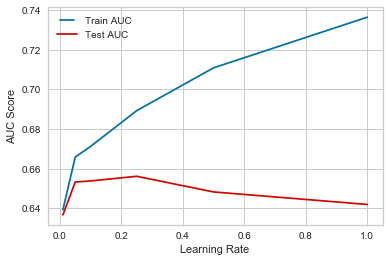

In [27]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Learning Rate')
plt.show()

In [28]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

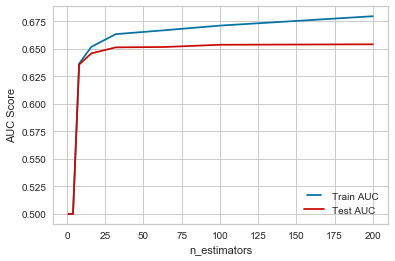

In [29]:
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('n_estimators')
plt.show()

In [31]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

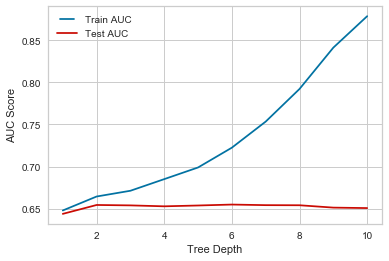

In [32]:
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()

In [35]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

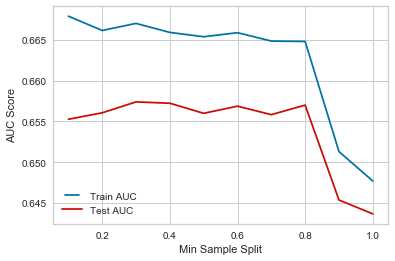

In [36]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Min Sample Split')
plt.show()

In [37]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

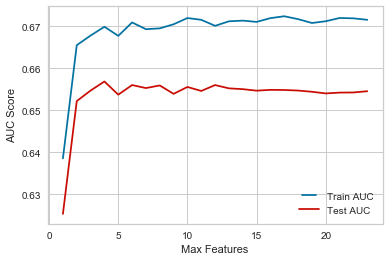

In [38]:
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Max Features')
plt.show()